# Datas Analysis

    1.Convert data from the raw txt file into a table in a CSV file
    2.Plot final report, graphs and trajectory on a map
    3.Correlation between datas
    4.Condition Datas in order to apply convolutional neural networks on them
    5.Apply Convolutional neural network on datas

In [2]:
import math
import pandas as pd
import numpy as np
import re
import csv
from datetime import datetime
import folium
from folium import plugins
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.preprocessing import MinMaxScaler

1. Convert data from the raw txt file into a table in a CSV file

In [14]:
# Convert date into ms
def date_to_ms(date):
    date_format = "%Y-%m-%dT%H:%M:%S.%fZ"
    # Parse the date string into a datetime object
    date_object = datetime.strptime(date, date_format)
    # Calculate the timestamp in seconds
    timestamp_seconds = date_object.timestamp()
    # Convert the timestamp to milliseconds
    timestamp_milliseconds = int(timestamp_seconds * 1000)
    return(timestamp_milliseconds)

# convert Swedish local time (ms) into UTC time (ms)
def local_to_UTC(local_time):
    # remove 2 hours
#     print("local_time",local_time)
#     print("utc_time",local_time - 1000*60*60*2)
    return (int(local_time) - 1000*60*60*2)

file_path = "C:\\Users\\jerem\\Documents\\TrundleWheel\\Data\\User1_Jeremy_Bezancon\\walkDatas_1"

with open(file_path+'.txt', 'r') as fichier:
    txt_file = fichier.readlines()
    csv_tab = [] # table that will be written to a CSV file
    csv_line = [] # line of the csv_table
    counter = 0 # number of lines

    if txt_file[0][27:49] == "E - signal check start":
        # this is the start signal -> file is good
        
        for line in txt_file[1:-1]:    
            csv_line = [] # each lines of the csv file
            csv_line.append(date_to_ms(line[0:24])) # time
            
            if line[27] == "O": # orientation
#                 [o_alpha, o_beta, o_gamma]
                k = 62
                for i in range(0,3):
                    index_1 = line[k:-1].find(":") + k+1 # return index of the first ":" in the line after kth caracter
                    if i < 2:
                        index_2 = line[k:-1].find(",") + k # return index of the first "," in the line after kth caracter
                    else:
                        index_2 = len(line)-2
                    k = index_2 + 1
                    csv_line.append(line[index_1:index_2])
                for i in range(0,17): csv_line.append(None) # fill the table
                                        
            elif line[27] == "M":
#                 [m_acc_x, m_acc_y, m_acc_z, m_accG_x, m_accG_y, m_accG_z, m_rotTate_alpha, m_rotTate_beta, m_rotTate_gamma]
                for i in range(0,3): csv_line.append(None) # fill the table
                k = 48
                for i in range(0,9):
                    index_1 = line[k:-1].find(":") + k+1 # return index of the first ":" in the line after kth caracter
                    index_2 = line[k:-1].find(",") + k # return index of the first "," in the line after kth caracter
                    k = index_2 + 1
                    if i == 2 :
                        k = index_2 + 9
                        index_2 -= 1 
                    elif i == 5 :
                        k = index_2 + 11
                        index_2 -= 1 
                    elif i == 8 :
                        index_2 -= 1      
                    csv_line.append(line[index_1:index_2])
                for i in range(0,8): csv_line.append(None) # fill the table
                
            elif line[27] == "P":
#                 [p_lat, p_long, p_alt, p_acc, p_head, p_speed]
                for i in range(0,12): csv_line.append(None) # fill the table
                csv_line[0] = local_to_UTC(line[53:66]) # replace time with the real timestamp
                k = 86
                for i in range(0,6):
                    index_1 = line[k:-1].find(":") + k+1 # return index of the first ":" in the line after kth caracter
                    index_2 = line[k:-1].find(",") + k # return index of the first "," in the line after kth caracter
                    k = index_2 + 1
                    if i == 5:
                        index_2 = len(line)-3   
                    csv_line.append(line[index_1:index_2])
                for i in range(0,2): csv_line.append(None) # fill the table

            elif line[27] == "S":
#                 [s_number]
                for i in range(0,18): csv_line.append(None) # fill the table
                index = line[27:-1].rfind(":") + 28 # return index of the last ":" in the line
                csv_line.append(line[index:len(line)-2])
                csv_line.append(None)
            elif line[27] == "D":
#                 [distance]
                for i in range(0,19): csv_line.append(None) # fill the table
                csv_line.append(line[40:-1])
            
            csv_tab.append(csv_line)
#             print(csv_line)
            counter+=1    
        
        # add final report
        line = txt_file[-1]
        k = 50
        for i in range(0,6):
            index_1 = line[k:-1].find(":") + k+1 # return index of the first ":" in the line after kth caracter
            if i<5:
                index_2 = line[k:-1].find(",") + k # return index of the first "," in the line after kth caracter
            else:
                index_2 = len(line)-3
            k = index_2 + 1
            if i == 1 or i == 4 or i == 5:
                index_1 += 1
                index_2 -= 1
            if i == 3 :
                k = index_2 + 13                
            csv_tab[0].append(line[index_1:index_2])        
    
# Save csv_tab to a CSV file
with open(file_path+'.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile, delimiter=';') # the delimeter for a CSV file in France is a ';'
    header_3 = ["time", "o_alpha", "o_beta", "o_gamma", "m_acc_x", "m_acc_y", "m_acc_z", "m_accG_x", "m_accG_y", "m_accG_z",
              "m_rotTate_alpha", "m_rotTate_beta", "m_rotTate_gamma", "p_lat", "p_long", "p_alt", "p_acc", "p_head", "p_speed",
              "steps", "distance","duration","date","total_distance","total_steps","device_os","device_model"]
    csv_writer.writerow(header_3)

    for csv_line in csv_tab:
        csv_writer.writerow(csv_line)

print("CSV file saved successfully.")

CSV file saved successfully.


In [41]:
# Read Datas CSV File
file_path = "C:\\Users\\jerem\\Documents\\TrundleWheel\\Data\\User1_Jeremy_Bezancon\\walkDatas_1"
data = pd.read_csv(file_path+'.csv', sep=';')

C:\Users\jerem\AppData\Local\Temp\ipykernel_7120\3714255974.py:3: DtypeWarning: Columns (22,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path+'.csv', sep=';')


2. Plot final report, graphs and trajectory on a map

In [7]:
# Final report:
print("final report")
data.iloc[0:1,21:26]

final report


duration                      date  total_distance  total_steps  \
0  15.147117  2023-07-13T14:32:06.703Z          1250.0       1551.0   

    device_os  
0  Android 10

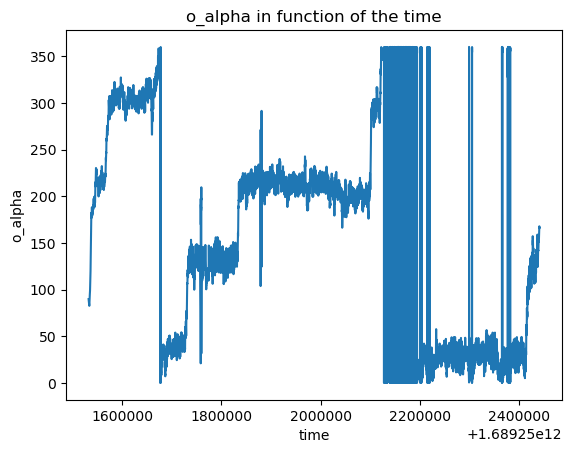

count    53717.000000
mean       153.619955
std        108.355074
min          0.000000
25%         34.500000
50%        184.200000
75%        218.100000
max        360.000000
Name: o_alpha, dtype: float64


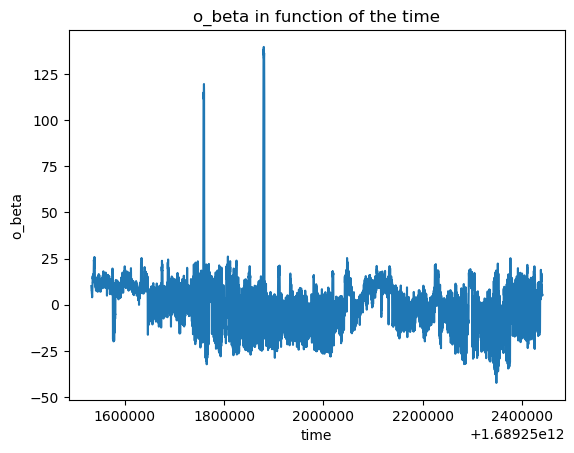

count    53717.000000
mean        -1.443223
std         14.454919
min        -42.400000
25%        -11.400000
50%         -1.900000
75%          8.700000
max        139.700000
Name: o_beta, dtype: float64


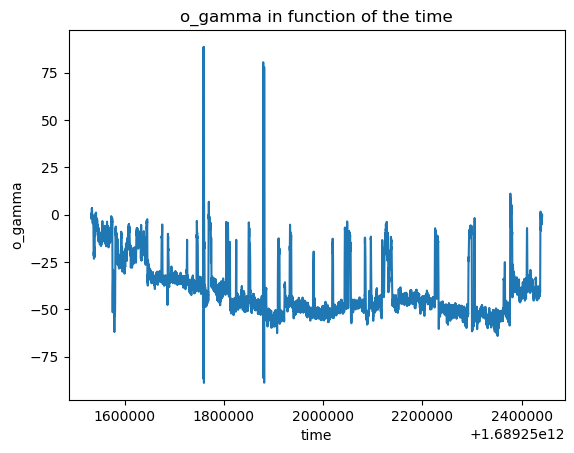

count    53717.000000
mean       -38.724960
std         14.768151
min        -88.900000
25%        -49.500000
50%        -43.900000
75%        -32.900000
max         88.600000
Name: o_gamma, dtype: float64


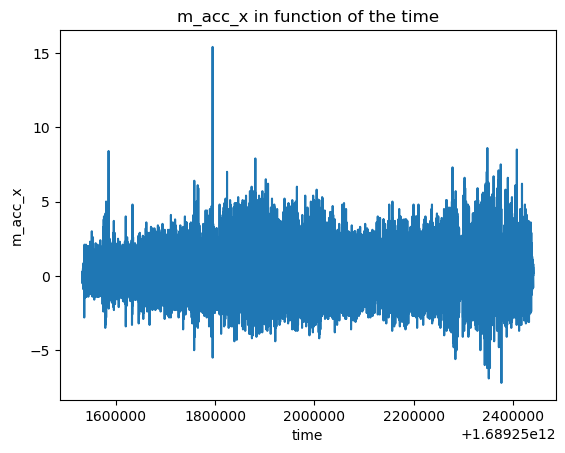

count    54470.000000
mean         0.124997
std          1.685382
min         -7.200000
25%         -1.100000
50%         -0.100000
75%          1.100000
max         15.400000
Name: m_acc_x, dtype: float64


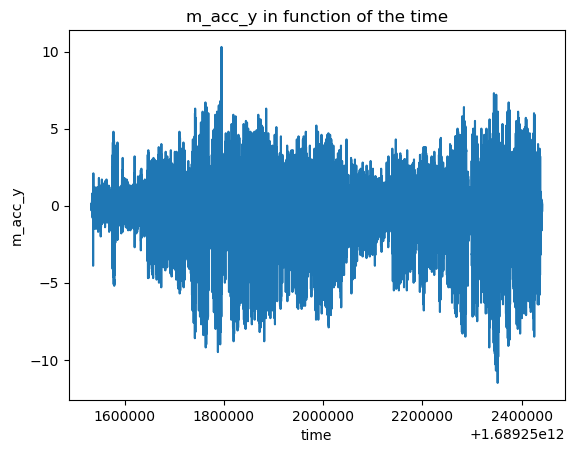

count    54470.000000
mean        -0.241285
std          2.382053
min        -11.500000
25%         -1.200000
50%          0.200000
75%          1.300000
max         10.300000
Name: m_acc_y, dtype: float64


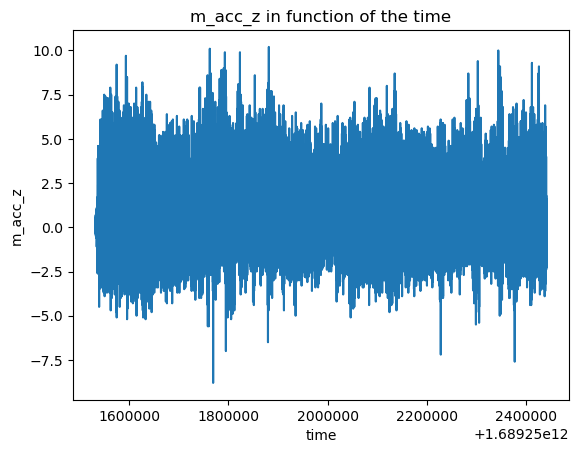

count    54470.000000
mean         0.307656
std          2.134370
min         -8.800000
25%         -1.200000
50%          0.000000
75%          1.600000
max         10.200000
Name: m_acc_z, dtype: float64


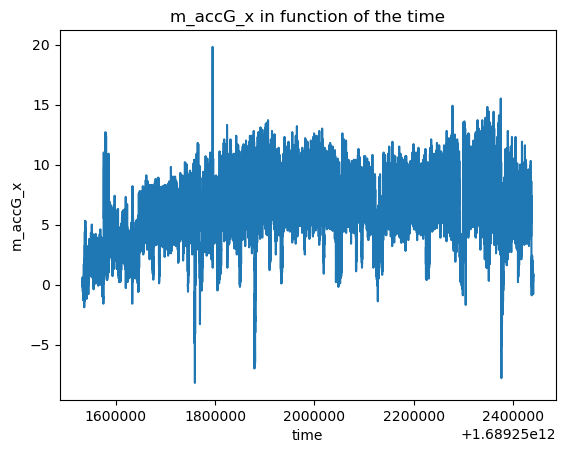

count    54470.000000
mean         5.959409
std          2.731930
min         -8.200000
25%          4.400000
50%          6.100000
75%          7.700000
max         19.800000
Name: m_accG_x, dtype: float64


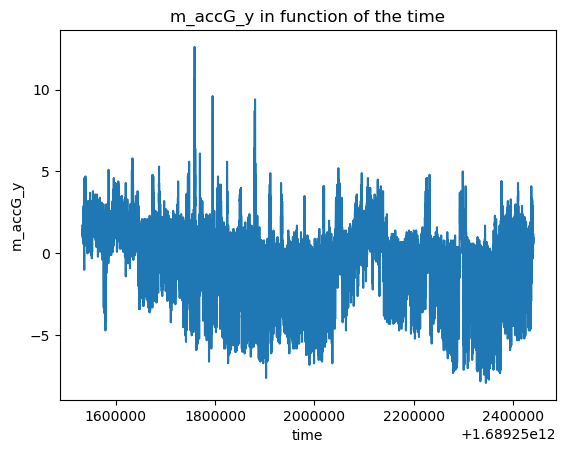

count    54470.000000
mean        -0.528175
std          2.187890
min         -7.900000
25%         -1.900000
50%         -0.500000
75%          1.100000
max         12.600000
Name: m_accG_y, dtype: float64


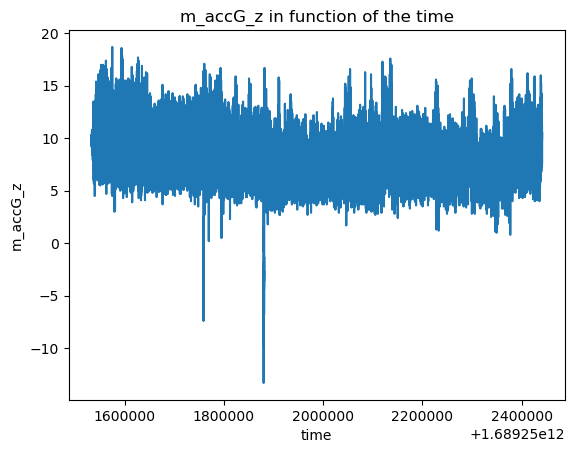

count    54470.000000
mean         7.573872
std          2.467940
min        -13.300000
25%          5.800000
50%          7.300000
75%          9.200000
max         18.700000
Name: m_accG_z, dtype: float64


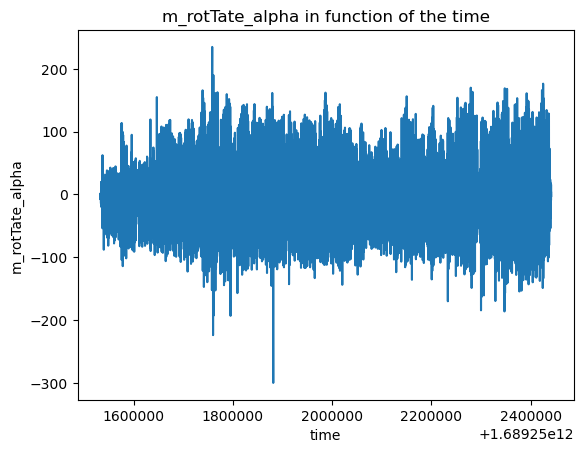

count    54470.000000
mean         0.072482
std         52.657943
min       -300.100000
25%        -34.700000
50%         -5.400000
75%         30.700000
max        234.900000
Name: m_rotTate_alpha, dtype: float64


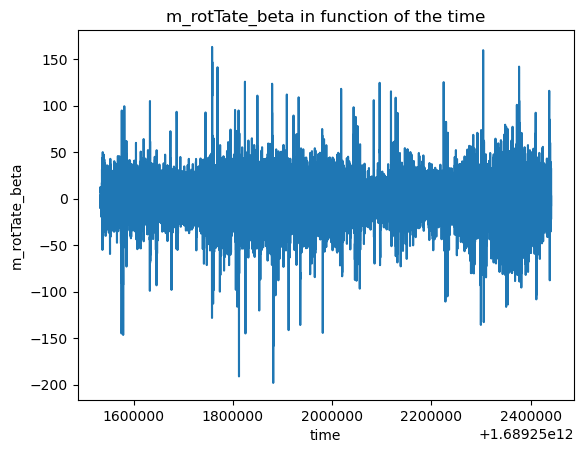

count    54470.000000
mean        -1.626339
std         23.429905
min       -198.300000
25%        -14.200000
50%         -1.000000
75%         11.500000
max        163.200000
Name: m_rotTate_beta, dtype: float64


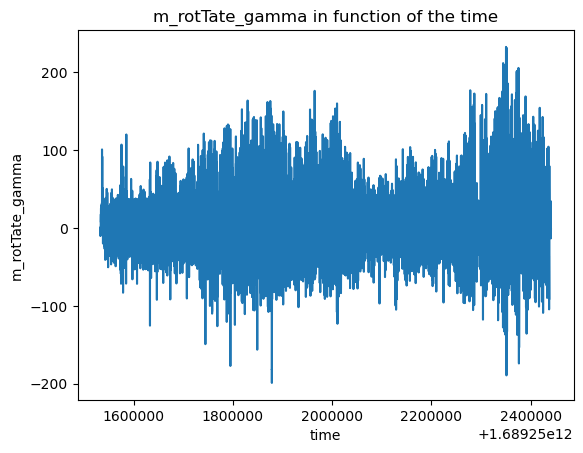

count    54470.000000
mean         0.740617
std         38.863573
min       -199.000000
25%        -20.900000
50%         -1.000000
75%         20.300000
max        232.700000
Name: m_rotTate_gamma, dtype: float64


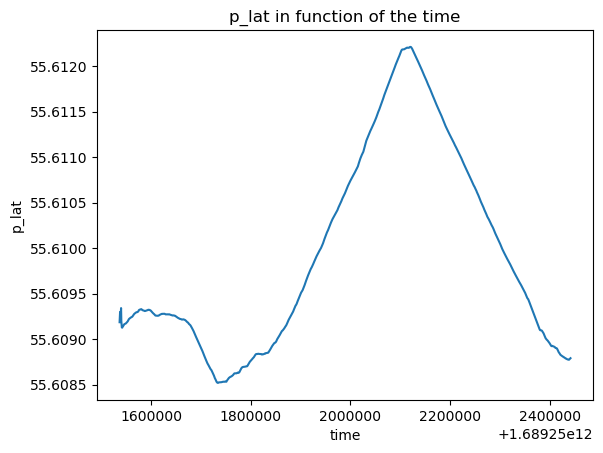

count    907.000000
mean      55.609938
std        0.001105
min       55.608518
25%       55.609062
50%       55.609482
75%       55.610832
max       55.612211
Name: p_lat, dtype: float64


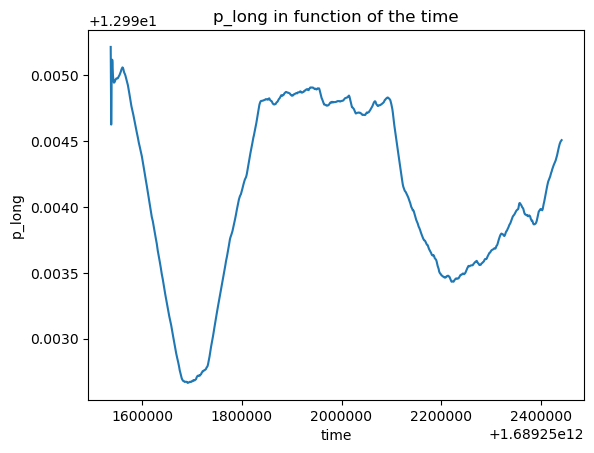

count    907.000000
mean      12.994098
std        0.000678
min       12.992664
25%       12.993588
50%       12.994059
75%       12.994785
max       12.995215
Name: p_long, dtype: float64


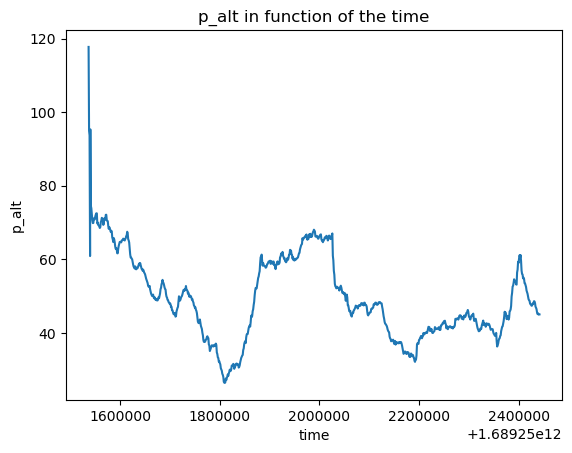

count    907.000000
mean      49.562165
std       11.477786
min       26.430420
25%       41.276245
50%       47.657104
75%       58.850372
max      117.733826
Name: p_alt, dtype: float64


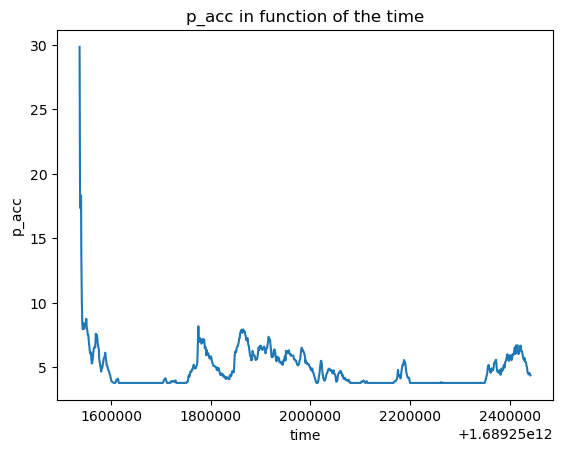

count    906.000000
mean       4.837683
std        1.642924
min        3.790092
25%        3.790092
50%        4.263542
75%        5.570235
max       29.843763
Name: p_acc, dtype: float64


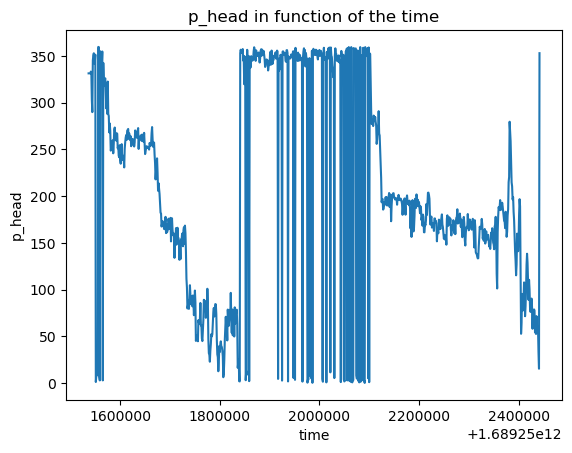

count    904.000000
mean     204.291261
std      110.582959
min        0.100000
25%      146.324997
50%      188.599998
75%      331.500000
max      359.799988
Name: p_head, dtype: float64


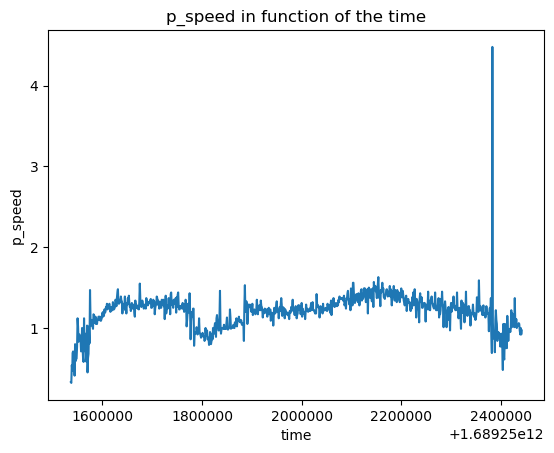

count    907.000000
mean       1.202095
std        0.218777
min        0.320000
25%        1.120000
50%        1.240000
75%        1.310000
max        4.480014
Name: p_speed, dtype: float64


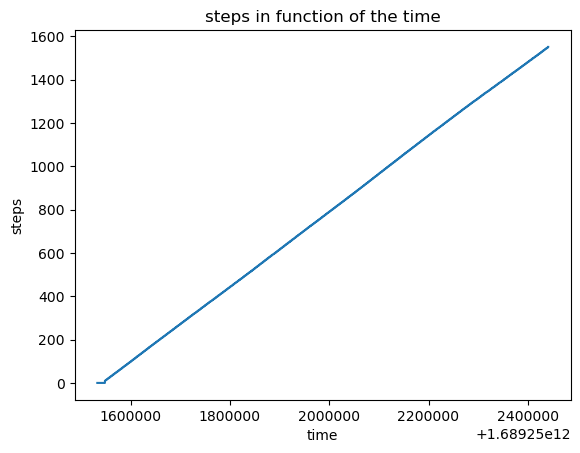

count    1552.000000
mean      775.500644
std       448.167008
min         1.000000
25%       387.750000
50%       775.500000
75%      1163.250000
max      1551.000000
Name: steps, dtype: float64


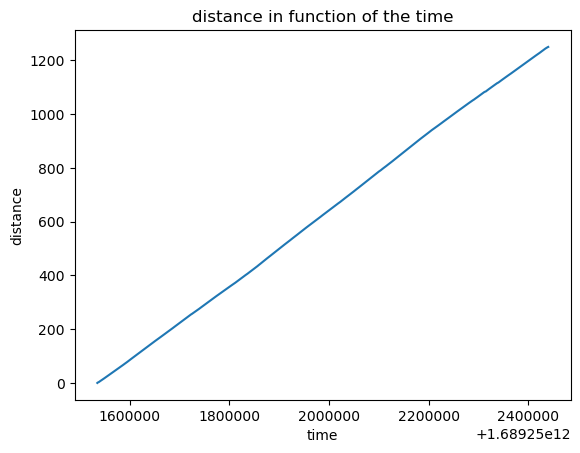

count    1251.000000
mean      625.000000
std       361.276902
min         0.000000
25%       312.500000
50%       625.000000
75%       937.500000
max      1250.000000
Name: distance, dtype: float64


In [13]:
# plot graphs
for column in data.columns[1:-1]:
    if column == 'duration': break;
        
    data_dropna = data.dropna(subset=[column]) # remove lines where there isn't datas 

#     mean = data_dropna[column].mean()
#     std = data_dropna[column].std() 
#     threshold = mean + 3*std
#     data_filtered = data_dropna[data_dropna[column] <= threshold] # remove extrem values
    
#     x = data_filtered.time
#     y = data_filtered[column]

    x = data_dropna.time
    y = data_dropna[column]
    
    plt.plot(x,y)
    plt.xlabel('time')
    plt.ylabel(column)
    plt.title(column+' in function of the time')
    plt.show()
    
    print(data_dropna[column].describe())



In [16]:
# plot trajectory on the map

# Coordinates for Malmö, Sweden
malmö_coords = (55.604980, 13.003822)
map_malmö = folium.Map(location=malmö_coords, zoom_start=14)

# keep only the lines where GPS coord is available
data_GPS = data.dropna(subset=['p_lat']) 

# Create a list of latitude and longitude coordinates
points = data_GPS[['p_lat', 'p_long']].values.tolist()

# Add the polyline to the map
folium.PolyLine(points, color='blue', weight=5, opacity=0.7).add_to(map_malmö)

map_malmö




4. Condition Datas in order to apply convolutional neural networks on them

In [148]:
# 1. Fill all the cells in the distance column (20th column) by adding intermediate values
# 2. Fill all the cells in the steps column (19th column) by adding intermediate values
# 3. Synchronyze position, speed and acceleration timestamp
# 4. Only keep completely filled rows
# 5. Remove orientation columns

# Read Datas CSV File
file_path = "C:\\Users\\jerem\\Documents\\TrundleWheel\\Data\\User1_Jeremy_Bezancon\\walkDatas_1"
data = pd.read_csv(file_path+'.csv', sep=';')

# 1. Fill all the cells in the distance column (20th column) by adding intermediate values
interval = [] # number of empty cells between filled cells
interval.append(0)
k=0;
y = data['distance'].values
y[1] = 0

for i in y[1:-1]:
    if not np.isnan(i): # if the cell is filled
        interval.append(1)
        k+=1
    else:
        interval[k]+=1
interval[1]+=1

k=-1 # number of the current interval
count = 1 # number of the current line
line = 0  # number of the next line where the cell is filled
for i in y[1:-1]:
    if not np.isnan(i): # if the cell is filled
        k +=1
        line += interval[k]
    else:
        y[count] = y[count-1]+((y[line + interval[k+1]]-y[line])/interval[k+1]) # calculate the interpolated data
    count+=1
    
data['distance'] = y

# 2. Fill all the cells in the steps column (19th column) by adding intermediate values
interval = [] # number of empty cells between filled cells
interval.append(0)
k=0;
y = data['steps'].values
y[1] = 0

for i in y[1:-1]:
    if not np.isnan(i): # if the cell is filled
        interval.append(1)
        k+=1
    else:
        interval[k]+=1
interval[1]+=1

k=-1 # number of the current interval
count = 1 # number of the current line
line = 0  # number of the next line where the cell is filled
for i in y[1:-1]:
    if not np.isnan(i): # if the cell is filled
        k +=1
        line += interval[k]
    else:
        y[count] = y[count-1]+((y[line + interval[k+1]]-y[line])/interval[k+1]) # calculate the interpolated data
    count+=1
    
data['steps'] = y

# 3. Synchronyze position, speed and acceleration timestamp:
# positon and speed datas are logged on the same row whereas acceleration is on a different row 
# because data arrived at different timestammps
# we need all the rows completely filled in order to use the neural network on all the datas
# So we will put position and speed data at the closest acceleration timestamp so they will be on the same row
# (each row is at a different timestamp)

data_dropna_acc = data_conditioned.dropna(subset=['m_acc_x']) # remove lines where there isn't acceleration datas 
data_dropna_pos = data_conditioned.dropna(subset=['p_speed']) # remove lines where there isn't position and speed datas
count = 0
new_row = 0

# csv_writer = csv.writer(data, delimiter=';')
#     header_3 = ["time", "o_alpha", "o_beta", "o_gamma", "m_acc_x", "m_acc_y", "m_acc_z", "m_accG_x", "m_accG_y", "m_accG_z",
#               "m_rotTate_alpha", "m_rotTate_beta", "m_rotTate_gamma", "p_lat", "p_long", "p_alt", "p_acc", "p_head", "p_speed",
#               "steps", "distance","duration","date","total_distance","total_steps","device_os","device_model"]
#     csv_writer.writerow(header_3

if(len(data_dropna_acc)>len(data_dropna_pos)): # there are more acc data than pos data
#     we put position and speed data at the closest acceleration timestamp
    for row in data.itertuples(index=False):
        if not np.isnan(row[4]): # if the row of the m_acc_x column is not empty
            new_row = count
        if not np.isnan(row[18]): # if the row of the p_speed column is not empty
            # put the pos and speed data on the new_timestamp (i.e on the previous acceleration line)
            data.loc[new_row,'p_lat':'p_speed'] = data.iloc[count,13:19]
        count+=1
else: # there are more pos data than acc data
#     we put acc data at the closest pos timestamp
    for row in data.itertuples:
        if not np.isnan(row[18]): # if the row of the p_speed column is not empty
            new_row = count
        if not np.isnan(row[4]): # if the row of the m_acc_x column is not empty
            # put the acc data on the new_timestamp (i.e on the previous pos line)
            data.loc[new_row,'m_acc_x':'m_rotTate_gamma'] = data.iloc[count,4:13]
        count+=1

# 4. Keep only completely filled lines 
# remove orientation columns (orientation data are not really meaningfull)
# Delete datas before distance=0 and after the last meter
count = 0
new_tab = []
line = []
line.append(data.columns[0])
line.extend(data.columns[4:21])
new_tab.append(line)
for index, row in data.iterrows():
    if row.iloc[4:21].notna().all():
        line = []
        line.append(row[0])
        line.extend(row[4:21])
        new_tab.append(line)

# Save file
import csv
with open(file_path+'_conditioned.csv', 'w', newline='') as new_csvfile:
    csv_writer = csv.writer(new_csvfile, delimiter=';') # the delimeter for a CSV file in France is a ';'
    for row in new_tab:
        csv_writer.writerow(row)

print("new CSV file saved successfully.")
    
    
    

C:\Users\jerem\AppData\Local\Temp\ipykernel_7120\473728636.py:9: DtypeWarning: Columns (22,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path+'.csv', sep=';')


new CSV file saved successfully.


In [149]:
# correlation between datas:
file_path = "C:\\Users\\jerem\\Documents\\TrundleWheel\\Data\\User1_Jeremy_Bezancon\\walkDatas_1_conditioned"
data_conditioned = pd.read_csv(file_path+'.csv', sep=';')

# X = data_dropna.iloc[:,4:13].values
# y = data_dropna[['distance']]

# data.iloc[:,4:13+20].head()
corr_matrix = data_conditioned.corr()
corr_matrix["distance"]

time               0.999926
m_acc_x            0.016866
m_acc_y           -0.009763
m_acc_z            0.047366
m_accG_x           0.350505
m_accG_y          -0.338603
m_accG_z          -0.210248
m_rotTate_alpha    0.015699
m_rotTate_beta     0.011428
m_rotTate_gamma    0.018527
p_lat              0.423004
p_long            -0.024555
p_alt             -0.403131
p_acc             -0.229816
p_head            -0.183692
p_speed            0.188434
steps              0.999971
distance           1.000000
Name: distance, dtype: float64

5. Apply Convolutional neural network on datas

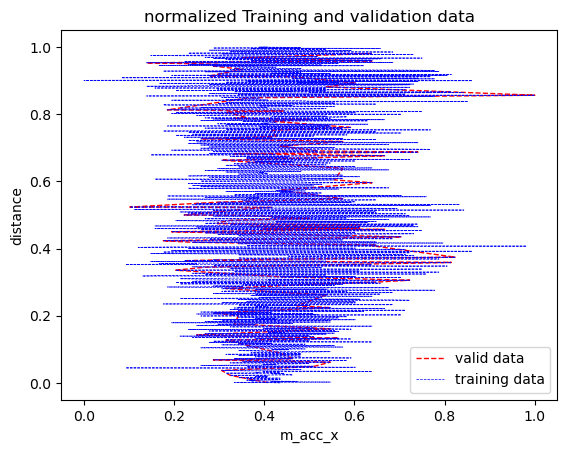

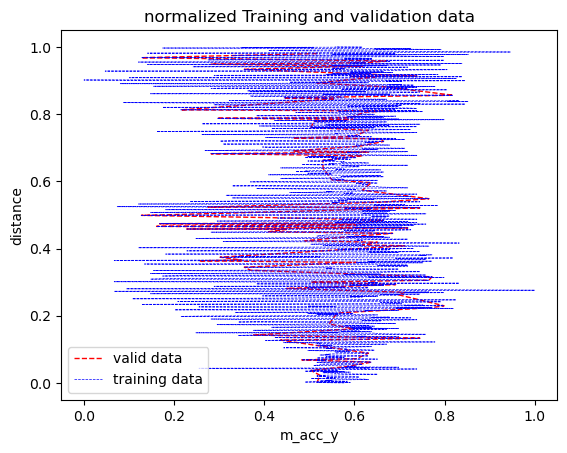

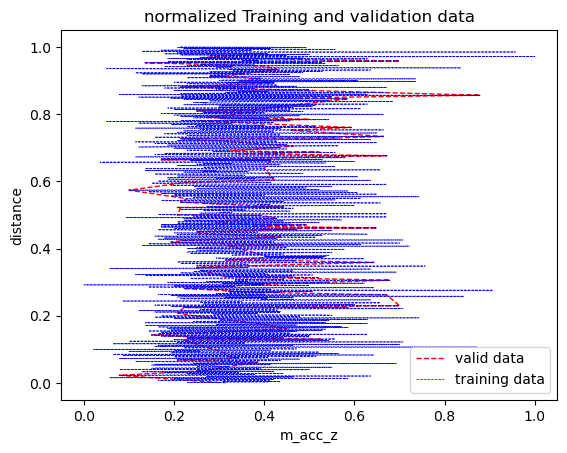

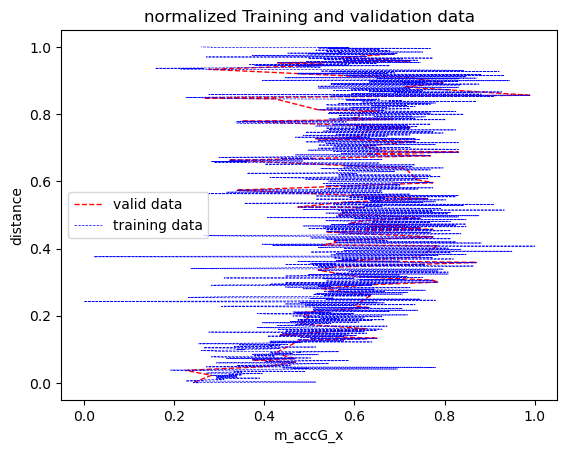

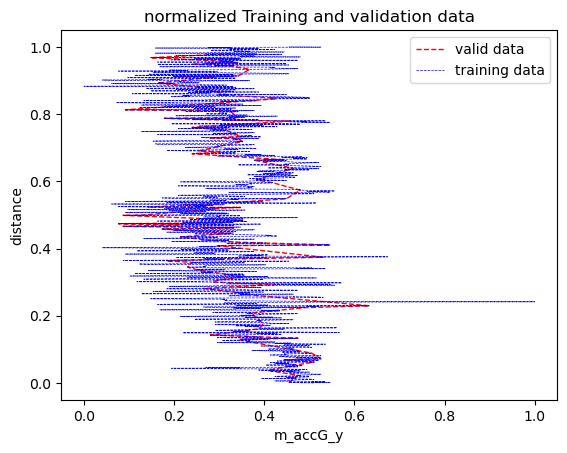

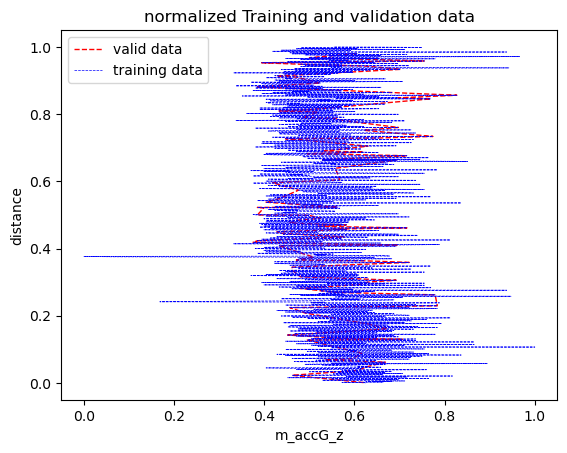

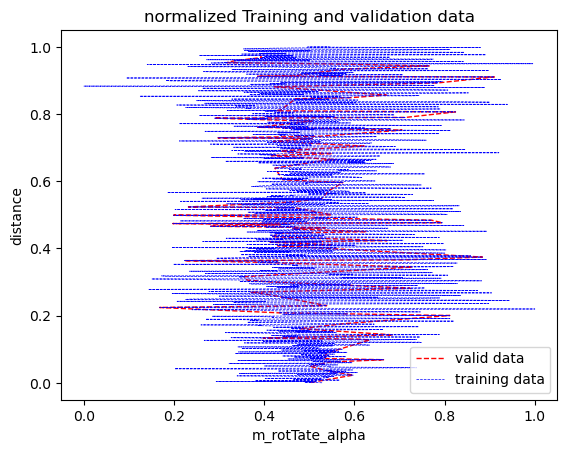

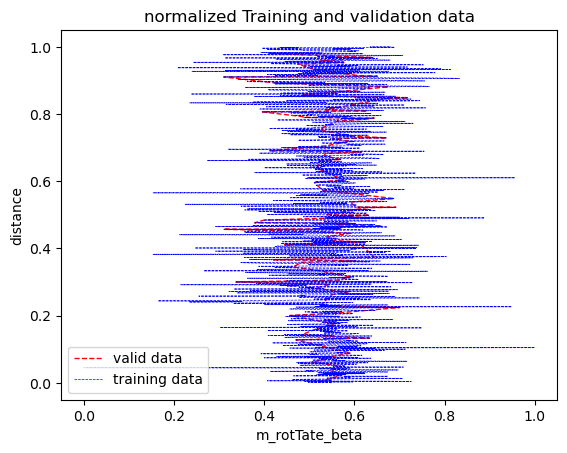

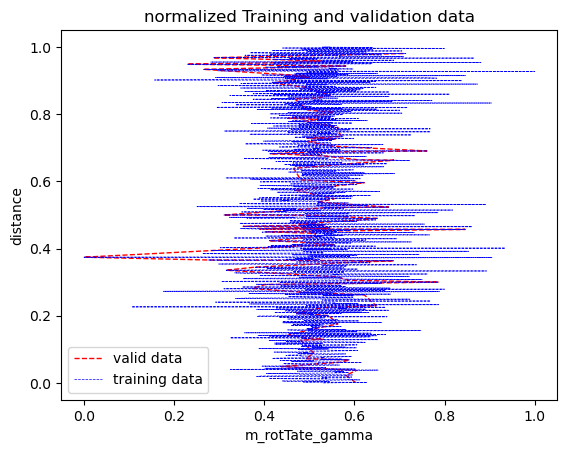

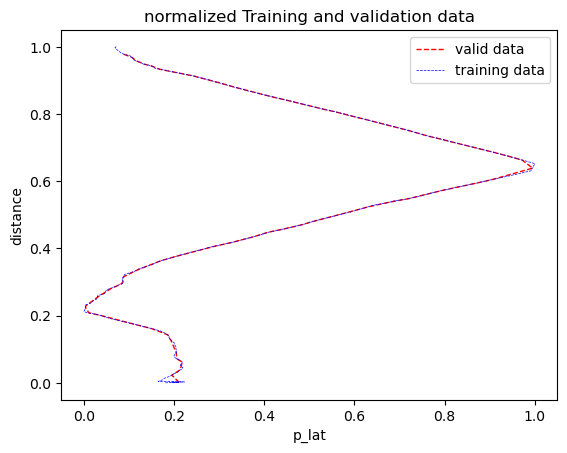

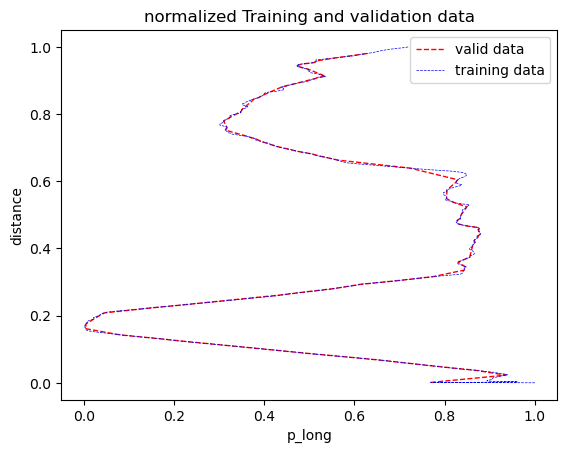

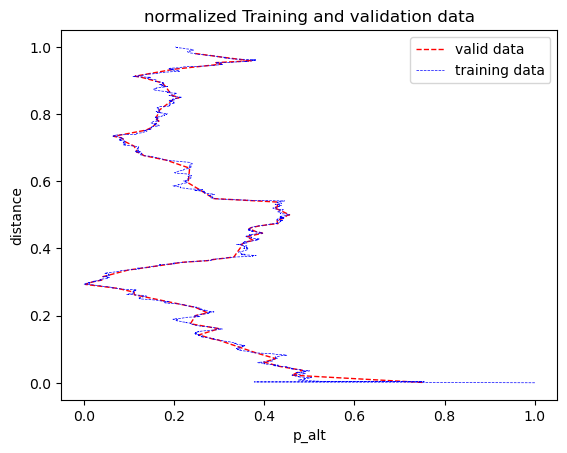

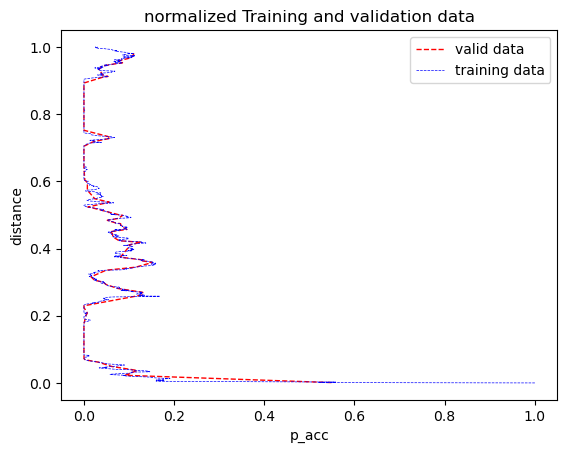

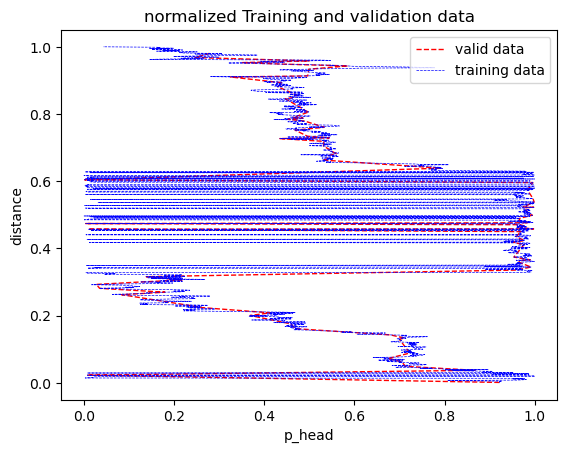

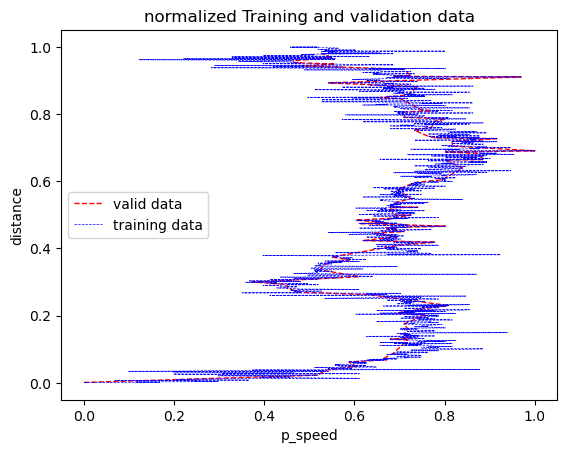

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 32)                512       
                                                                 
 dense_34 (Dense)            (None, 32)                1056      
                                                                 
 dense_35 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1601 (6.25 KB)
Trainable params: 1601 (6.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
91/91 [==============================] - 1s 4ms/step - loss: 0.0947 - mse: 0.0947 - val_loss: 0.0704 - val_mse: 0.0704
Epoch 2/10
91/91 [==============================] - 0s 2ms/step - loss: 0.0699 - mse: 0.0699 - val_loss: 0.0550 - val_mse: 0.0550
Epoch 3/10
91/91 [=======

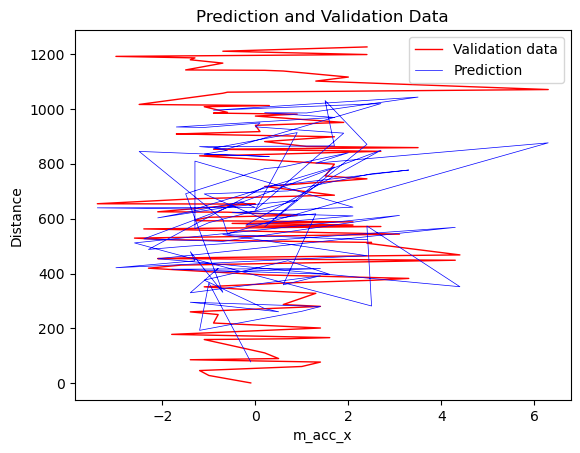

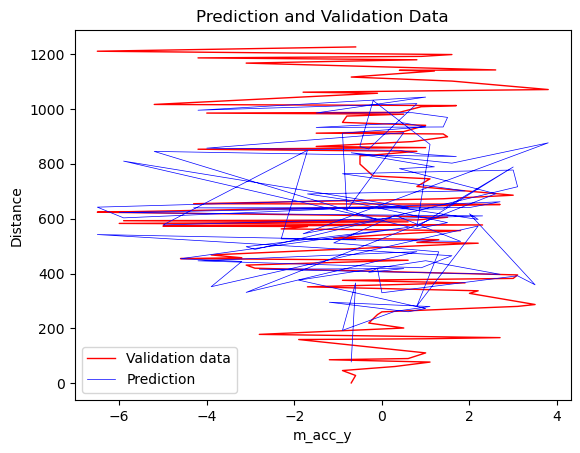

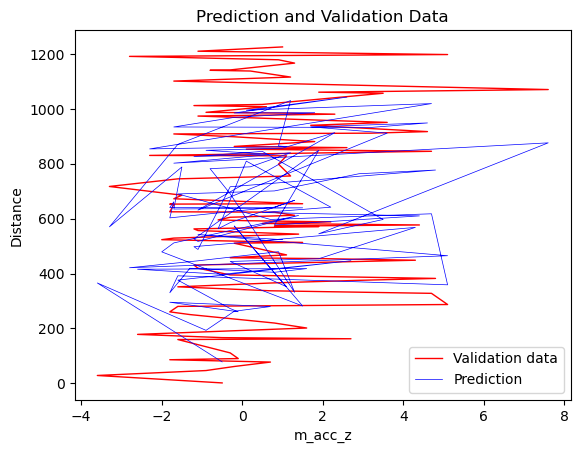

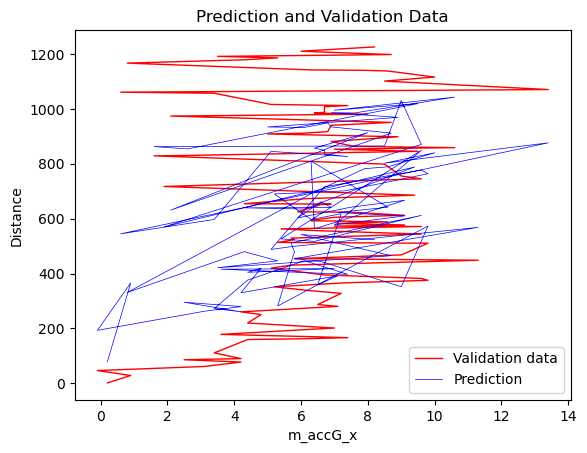

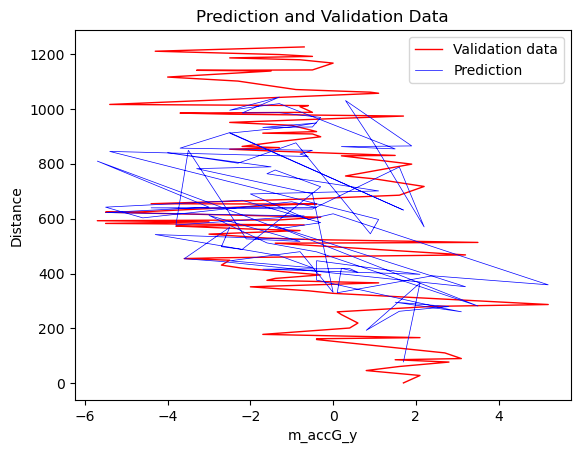

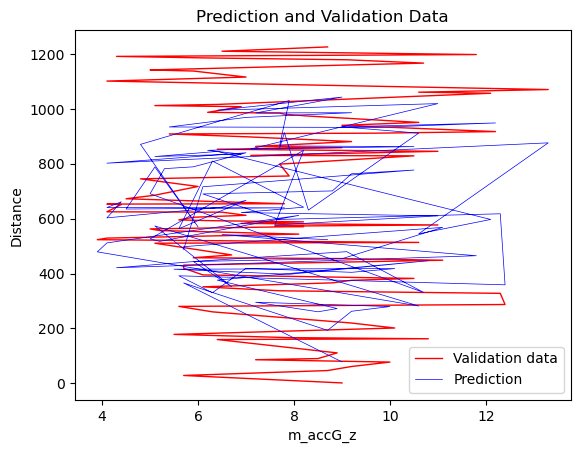

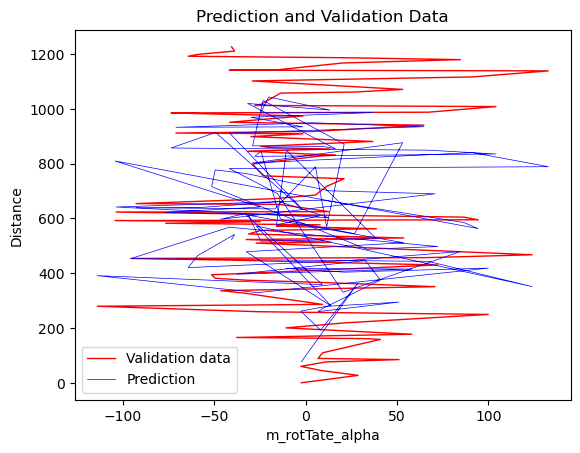

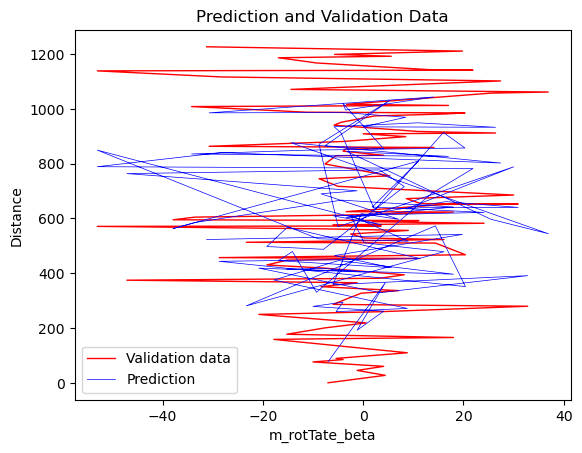

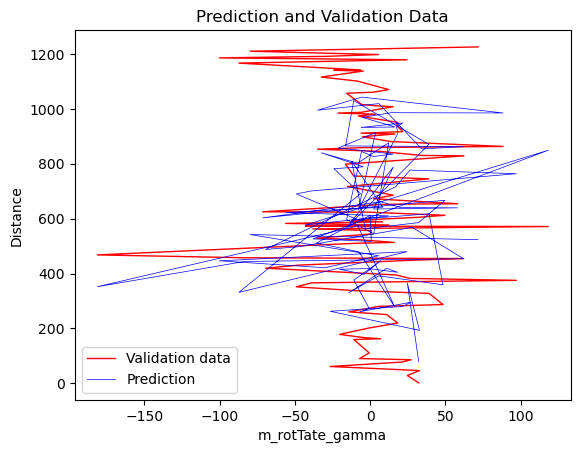

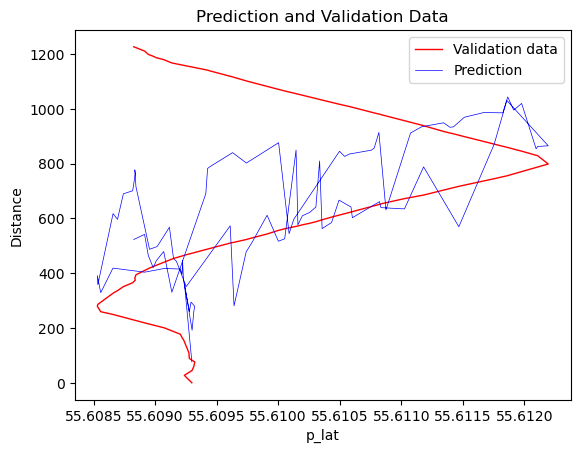

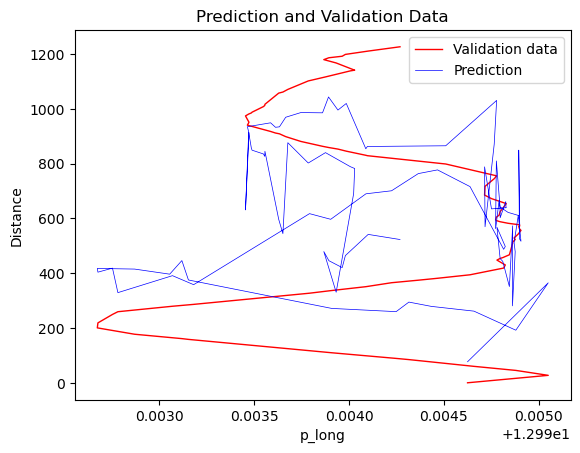

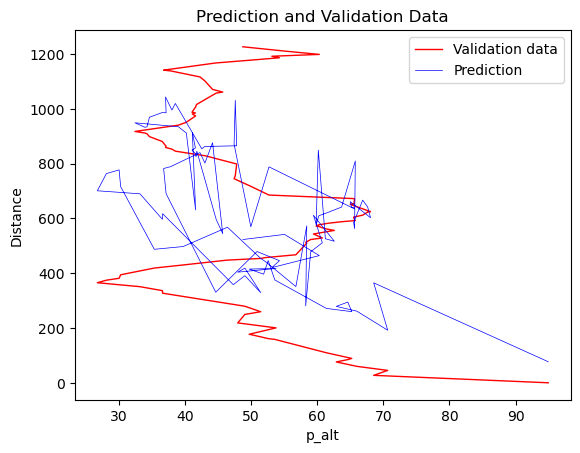

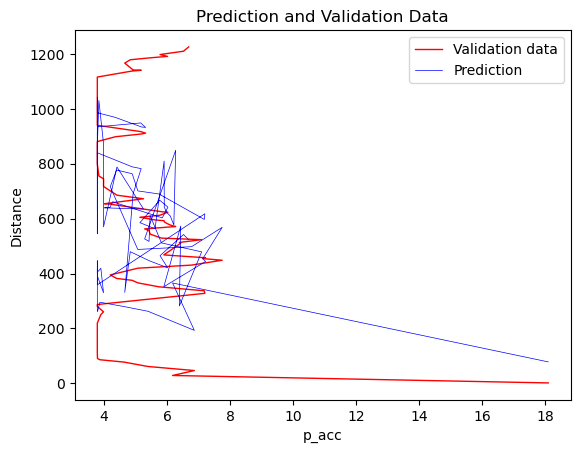

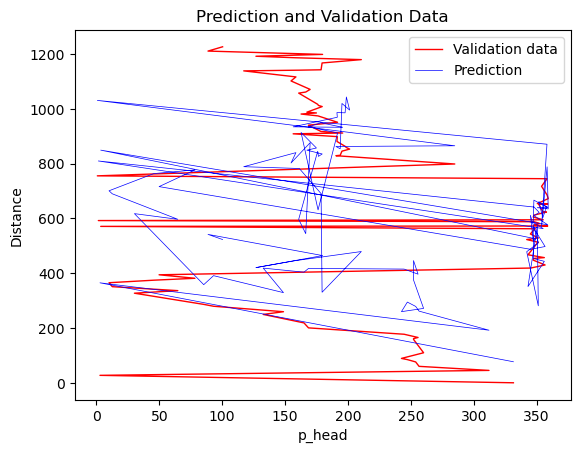

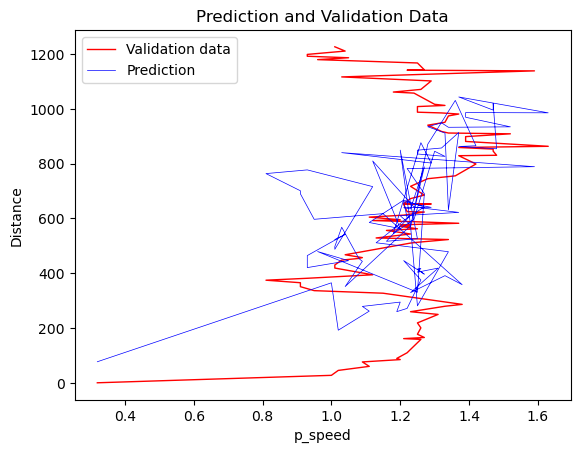

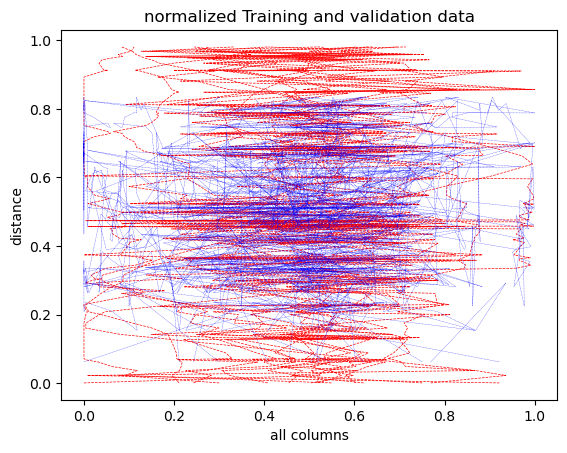

In [163]:
file_path = "C:\\Users\\jerem\\Documents\\TrundleWheel\\Data\\User1_Jeremy_Bezancon\\walkDatas_1_conditioned"
data_conditioned = pd.read_csv(file_path+'.csv', sep=';')

col_s = 0 # first column in data file
col_f = 17 # last column in data file
# first column is timestamp
# last column is the 17th, it's distance

#fix random seed for reproductability
seed = 7
np.random.seed(seed)

#training data
data_dropna = data_conditioned.dropna(subset=['steps']) # remove lines where there isn't datas 
X_train = data_dropna.iloc[:,col_s:col_f]
Y_train = data_dropna['distance']

#normalize data between 0 and 1
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train.values)
Y_train_normalized = Y_train.values / np.max(Y_train)  # Normalisation de la distance

#validation data
rand_line = np.random.rand(100)*len(X_train)
int_rand_line = []
for i in range(0,len(rand_line)): int_rand_line.append(math.trunc(rand_line[i]))
int_rand_line = np.sort(int_rand_line)
X_val = []
y_val = []
for i in range(0,100): 
    X_val.append(data_dropna.iloc[int_rand_line[i]][col_s:col_f])
    y_val.append(data_dropna.iloc[int_rand_line[i]]['distance'])

#convert validation data to NumPy arrays (ndarray)
X_val = np.array(X_val)
y_val = np.array(y_val)

#normalize data between 0 and 1
X_val_normalized = scaler.transform(X_val)
y_val_normalized = y_val / np.max(Y_train)

#plots
for i in range(0,col_f-col_s):
    plt.plot(pd.DataFrame(X_val_normalized).iloc[:,i],y_val_normalized,'r--', label='valid data', linewidth=1)
    plt.plot(pd.DataFrame(X_train_normalized).iloc[:,i],Y_train_normalized,'b--', label='training data', linewidth=0.5)
    plt.title('normalized Training and validation data')
    plt.xlabel(data_conditioned.columns[i+col_s])
    plt.ylabel('distance')
    plt.legend()
    plt.show()


model = Sequential()
model.add(Dense(32,input_dim = (col_f-col_s),kernel_initializer = 'uniform',activation='sigmoid'))
model.add(Dense(32,kernel_initializer = 'uniform',activation='sigmoid'))
# 32: number of neurons per layer
# input_dim: number of variables in input
# kernel_initializer: initialization method, here it's a uniform distribution
# activation: activation function (here, it's for all the layers except the last one cuse we're performiong a regression)

model.add(Dense(1,kernel_initializer = 'uniform'))

model.summary()

model.compile(optimizer = Adam(0.01),loss = 'mse',metrics=['mse'])
hist = model.fit(X_train_normalized,Y_train_normalized,epochs = 10,batch_size  = 10,validation_data =(X_val_normalized,y_val_normalized))

#compute model prediction on the validation data
y_p_normalized = model.predict(X_val_normalized)

# Return to true values by reversing normalization
y_val_restored = y_val_normalized  * np.max(Y_train)
y_p_restored = y_p_normalized * np.max(Y_train)

#plots
for i in range(0,col_f-col_s):
    plt.plot(X_val[:,i], y_val_restored, 'r-', label='Validation data', linewidth=1)
    plt.plot(X_val[:,i], y_p_restored, 'b-', label='Prediction',linewidth=0.5)
    plt.title('Prediction and Validation Data')
    plt.xlabel(data_conditioned.columns[i+col_s])
    plt.ylabel('Distance')
    plt.legend()
    plt.show()
    
#summarize plot
plt.plot(X_val_normalized[:],y_val_normalized,'r--', label='valid data', linewidth=0.5)
plt.plot(X_val_normalized[:],y_p_normalized,'b--', label='training data', linewidth=0.2)
plt.title('normalized Training and validation data')
plt.xlabel('all columns')
plt.ylabel('distance')
# plt.legend()
plt.show()

In [164]:
# Print the performance of the neural network
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate the rmse and MAE
rmse = np.sqrt(mean_squared_error(y_val_restored, y_p_restored))
mae = mean_absolute_error(y_val_restored, y_p_restored)

print(f'rmse: {rmse:.4f}') # average error
print(f'MAE: {mae:.4f}') # average absolute error


rmse: 273.1052
MAE: 194.1202


Text(0, 0.5, 'loss')

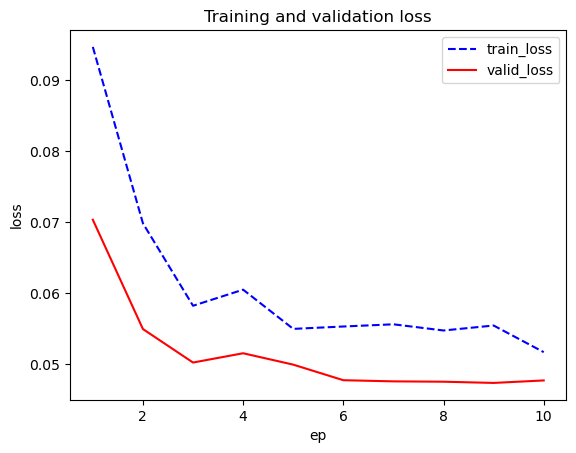

In [165]:
train_loss = hist.history['loss']
valid_loss = hist.history['val_loss']
ep = range(1,len(train_loss)+1)

plt.plot(ep,train_loss,'b--',label='train_loss')
plt.plot(ep,valid_loss,'r-',label='valid_loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('ep')
plt.ylabel('loss')

# if the curve don't stabilize it means that we can increase the number of Epochs (until the loss is as small as possible)

Text(0, 0.5, 'mse')

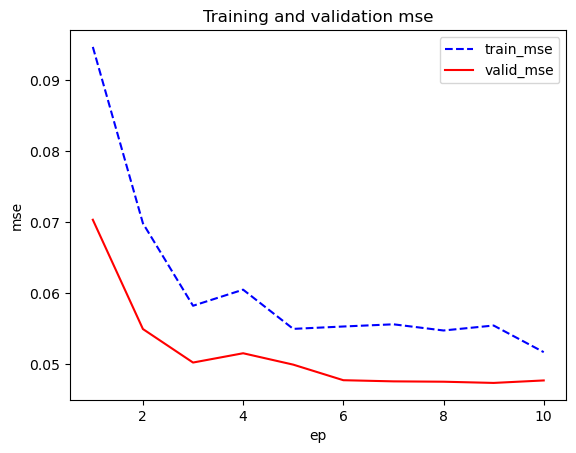

In [166]:
train_ac = hist.history['mse']
valid_ac = hist.history['val_mse']
ep = range(1,len(train_ac)+1)

plt.plot(ep,train_ac,'b--',label='train_mse')
plt.plot(ep,valid_ac,'r-',label='valid_mse')
plt.title('Training and validation mse')
plt.legend()
plt.xlabel('ep')
plt.ylabel('mse')

# if the curve don't stabilize it means that we can increase the number of Epochs (until the mse is as small as possible)